In [5]:
import os

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
from google.colab import auth
auth.authenticate_user()

In [8]:
folder_path = '/content/gdrive/MyDrive/DLS/HW2/'
os.chdir(folder_path)

In [6]:
!pip install librosa

In [9]:
#libraries
import librosa
import soundfile as sf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Q1.

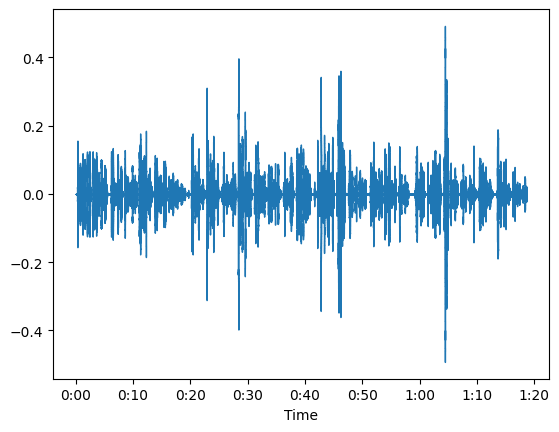

In [8]:
#plot of clean audio signal
s, sr=librosa.load('data/train_clean_male.wav', sr=None)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(s, sr=sr, ax=ax)

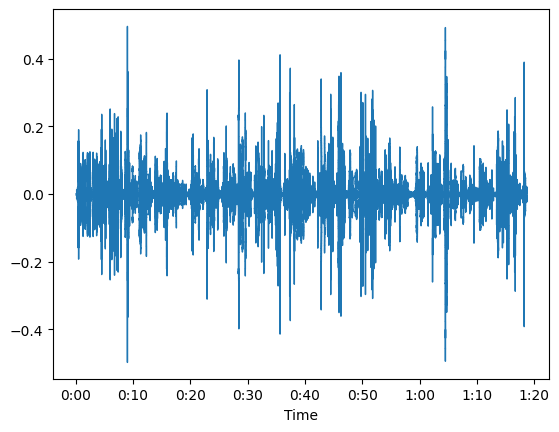

In [9]:
#plot of noisy audio signal
sn, sr=librosa.load('data/train_dirty_male.wav', sr=None)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(sn, sr=sr, ax=ax)

In [10]:
#calculate stft of the signals
s, sr=librosa.load('data/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('data/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)

In [11]:
S.shape
X.shape

(513, 2459)

In [12]:
#magnitude of clean and noisy signals
S_mag = np.abs(S).T
X_mag = np.abs(X).T

In [14]:
#deep neural network where input vector is column vector of 513 dim of X noisy signal
#and output vector is corresponding vector of S clean audio signal.

initializer = tf.keras.initializers.HeNormal()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = X_mag.shape[1]),
    tf.keras.layers.Dense(513 , activation = 'leaky_relu'),
    tf.keras.layers.Dense(513, activation = 'leaky_relu'),
    tf.keras.layers.Dense(units = S_mag.shape[1], activation = 'relu')
])

experiments:
no early stopping

1. epochs = 50 , batch size = 32 , snr = 6 , hidden: relu , He
2. epochs = 100, batch size = 16, snr = 4.96, hidden: relu , He
3. epochs = 50, batch size = 32, snr = 8.83, hidden: leaky relu , He
4. epochs = 50, batch size = 128, snr = 9.03, hidden: leaky relu , He
5. epochs = 100, batch size = 128, snr = -1.9, hidden: leaky relu , He
6. epochs = 200, batch size = 32, snr = 9.25, hidden : leaky relu , He; loss 0.028
7. epochs = 200, batch_size = 32, snr = 4.28, hidden : relu, He.
8. epochs = 200, batch_size = 32 , snr = 6. hidden : relu, 513 - kind of better than others.
9. epochs = 200, batch_size = 32 , snr = 9. hidden : leaky-relu, 513
10. epochs = 200, batch_size = 32 , snr =5  hidden : relu, 513-3

In [15]:
#train network
model.compile(optimizer = 'Adam', loss = 'mse', metrics = ['accuracy'])
history = model.fit(X_mag , S_mag, epochs = 200 , batch_size = 32, validation_split = 0.2, shuffle = True)

Epoch 1/200
62/62 [==============================] - 2s 7ms/step - loss: 0.0405 - accuracy: 0.1871 - val_loss: 0.0280 - val_accuracy: 0.2764
Epoch 2/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0171 - accuracy: 0.3620 - val_loss: 0.0194 - val_accuracy: 0.3394
Epoch 3/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0121 - accuracy: 0.3965 - val_loss: 0.0153 - val_accuracy: 0.3476
Epoch 4/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0088 - accuracy: 0.4296 - val_loss: 0.0135 - val_accuracy: 0.4126
Epoch 5/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0077 - accuracy: 0.4387 - val_loss: 0.0128 - val_accuracy: 0.4106
Epoch 6/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 0.4448 - val_loss: 0.0123 - val_accuracy: 0.4146
Epoch 7/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0066 - accuracy: 0.4565 - val_loss: 0.0124 - val_accuracy: 0.3984
Epoch 8/200
6

In [16]:
model.save('/content/gdrive/MyDrive/DLS/HW2/model_denoise.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/DLS/HW2/model_denoise.h5')

In [18]:
#load noisy signal for validation
x_test,sr =librosa.load('data/test_x_01.wav' , sr = None)
X_test = librosa.stft(x_test, n_fft = 1024, hop_length = 512).T
X_test_mod = np.abs(X_test)

In [19]:
X_test_mod.shape

(142, 513)

In [20]:
S_test_mod = model.predict(X_test_mod)
S_complex = np.multiply(np.divide(X_test, X_test_mod), S_test_mod)
#time domain signal
#apply ifft
s_test = librosa.istft(S_complex.T , win_length = 1024, hop_length = 512)
#reconstructed wav
sf.write('test_s_01_recons.wav', s_test, sr)

5/5 [==============================] - 0s 2ms/step


In [22]:
#snr:
#clean speech:
s , sr = librosa.load('data/test_s_01.wav')
#recovered speech:
shat, _ = librosa.load('test_s_01_recons.wav')

#truncate both to same length
min_length = min(len(s), len(shat))
s = s[:min_length]
shat = shat[:min_length]

#clean speech power
s_pow = np.sum(np.square(s))
#recovered speech power
noise_pow = np.sum(np.square(s-shat)) + 1e-20

#snr
snr_test1 = 10 * np.log10(s_pow / noise_pow)
snr_test1

9.716456314611452

In [23]:
#embed the test 1 noisy audio file
from IPython.display import Audio
wn = Audio('data/test_x_01.wav', autoplay=True)
display(wn)

In [24]:
#embed the test 1 reconstructed audio file
from IPython.display import Audio
wn = Audio('test_s_01_recons.wav', autoplay=True)
display(wn)

In [25]:
#test on second signal
#load noisy signal for validation
x_test2,sr =librosa.load('data/test_x_02.wav' , sr = None)
X_test2 = librosa.stft(x_test2, n_fft = 1024, hop_length = 512).T
X_test2_mod = np.abs(X_test2)

#predict clean magnitude spectra
S_test2_mod = model.predict(X_test2_mod)
S_complex2 = np.multiply(np.divide(X_test2, X_test2_mod), S_test2_mod)

#time domain signal
#apply ifft
s_test2 = librosa.istft(S_complex2.T , win_length = 1024, hop_length = 512)

#reconstructed wav
sf.write('test_s_02_recons.wav', s_test2, sr)

12/12 [==============================] - 0s 1ms/step


In [26]:
#embed the test 2 audio file
from IPython.display import Audio
wn = Audio('data/test_x_02.wav', autoplay=True)
display(wn)

In [27]:
#embed the test 2 reconstructed audio file
from IPython.display import Audio
wn = Audio('test_s_02_recons.wav', autoplay=True)
display(wn)

Q2.

In [28]:
#1D CNN does speech denoising in the stft magnitude domain
#1D CNN does convolution on any one axis , here the frequency axis.
#only one channel with magnitude unlike images that have 3 channels.

#dimensionality of minibatch : BX1X1X513
#kernel : 1XD
#output feature map: B X K X 1 X (513 - D -1)
#output matrix B X 513

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

experiments:
- 16,16 32,8, pool, strides 2, relu - all
- batch size 32 snr: 4.5 lr 0.002 , loss 0.005
- batch size 128 snr: 7.79 lr 0.0002 , loss : 0.004
- removing dropout. size 128 snr:9.54 , loss : e-4 , second half is better
- removing dropout and a dense,size 128, lr 0.002 snr :10.76 loss 0.0024 - still disturbance
- removing dropout and a dense,size 32, lr 0.001 snr: 9 loss:



In [30]:
model_1dcnn = Sequential()

#input (513 ,1)
model_1dcnn.add(Conv1D(filters = 16, kernel_size = 16, padding = "same", activation = "relu", input_shape = (513 , 1)))
#(513, 32)
model_1dcnn.add(MaxPooling1D(pool_size = 2 , strides = 2))
#(256, 32)
model_1dcnn.add(Conv1D(32, 8, padding = "same", strides =1 , activation = "relu"))
model_1dcnn.add(MaxPooling1D(pool_size = 2, strides = 2))
#(128, 64)
model_1dcnn.add(Flatten())
#model_1dcnn.add(Dense(1024, activation ="relu"))
#model_1dcnn.add(Dropout(0.3))
model_1dcnn.add(Dense(513, activation = "relu"))

In [31]:
model_1dcnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 513, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1  (None, 256, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 128, 32)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 513)              

In [32]:
model_1dcnn.compile(optimizer = Adam(learning_rate = 0.001) , loss = "mse", metrics = ["accuracy"])
history_1dcnn = model_1dcnn.fit(X_mag, S_mag, epochs = 200, batch_size = 32, validation_split = 0.2)

Epoch 1/200
62/62 [==============================] - 7s 7ms/step - loss: 0.0595 - accuracy: 0.0941 - val_loss: 0.0372 - val_accuracy: 0.1911
Epoch 2/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0258 - accuracy: 0.2700 - val_loss: 0.0260 - val_accuracy: 0.2724
Epoch 3/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0182 - accuracy: 0.3269 - val_loss: 0.0196 - val_accuracy: 0.3191
Epoch 4/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.3696 - val_loss: 0.0170 - val_accuracy: 0.3435
Epoch 5/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.4174 - val_loss: 0.0159 - val_accuracy: 0.3577
Epoch 6/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0097 - accuracy: 0.4347 - val_loss: 0.0145 - val_accuracy: 0.3943
Epoch 7/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0089 - accuracy: 0.4479 - val_loss: 0.0138 - val_accuracy: 0.3943
Epoch 8/200
6

In [33]:
model_1dcnn.save('/content/gdrive/MyDrive/DLS/HW2/model1dcnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
#load noisy signal for validation
x_test,sr = librosa.load('data/test_x_01.wav' , sr = None)
X_test = librosa.stft(x_test, n_fft = 1024, hop_length = 512).T
X_test_mod = np.abs(X_test)

In [35]:
from keras.models import load_model

model_1dcnn = load_model('model1dcnn.h5')

S_test_mod = model_1dcnn.predict(X_test_mod)
S_complex = np.multiply(np.divide(X_test, X_test_mod), S_test_mod)
#time domain signal
#apply ifft
s_test = librosa.istft(S_complex.T , win_length = 1024, hop_length = 512)
#reconstructed wav
sf.write('test_s_01_recons_1dcnn.wav', s_test, sr)

#snr:
#clean speech:
s , sr = librosa.load('data/test_s_01.wav')
#recovered speech:
shat, _ = librosa.load('test_s_01_recons_1dcnn.wav')

#truncate both to same length
min_length = min(len(s), len(shat))
s = s[:min_length]
shat = shat[:min_length]

#clean speech power
s_pow = np.sum(np.square(s))
#recovered speech power
noise_pow = np.sum(np.square(s-shat)) + 1e-20

#snr
snr_test1 = 10 * np.log10(s_pow / noise_pow)
snr_test1

5/5 [==============================] - 0s 6ms/step


8.886485974168945

In [36]:
#test on second signal
#load noisy signal for validation
x_test2,sr =librosa.load('data/test_x_02.wav' , sr = None)
X_test2 = librosa.stft(x_test2, n_fft = 1024, hop_length = 512).T
X_test2_mod = np.abs(X_test2)

#predict clean magnitude spectra
S_test2_mod = model_1dcnn.predict(X_test2_mod)
S_complex2 = np.multiply(np.divide(X_test2, X_test2_mod), S_test2_mod)

#time domain signal
#apply ifft
s_test2 = librosa.istft(S_complex2.T , win_length = 1024, hop_length = 512)

#reconstructed wav
sf.write('test_s_02_recons_1dcnn.wav', s_test2, sr)

12/12 [==============================] - 0s 3ms/step


In [37]:
#embed the test 2 audio file
from IPython.display import Audio
wn = Audio('data/test_x_02.wav', autoplay=True)
display(wn)

In [38]:
#embed the test 2 audio file
from IPython.display import Audio
wn = Audio('test_s_02_recons_1dcnn.wav', autoplay=True)
display(wn)

Q3. (was done on kaggle)

a. Baseline

In [ ]:
from keras.datasets import cifar10
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
#set aside 5000 examples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [ ]:
#reshape to 32x32x3
x_train = x_train.reshape(x_train.shape[0] , 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)

In [ ]:
x_train = x_train.astype('float32')
x_test = y_test.astype('float32')
x_val = x_val.astype('float32')

In [ ]:
#normalize to -1 to 1
x_train = x_train/255.0
x_val = x_val/255.0

x_train = x_train * 2 - 1
x_val = x_val * 2 - 1

In [ ]:
#categorical classes
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)

In [ ]:
#model
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",input_shape = (32,32,3),
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Flatten())
model.add(Dense(20, activation = "relu", kernel_initializer = "he_normal"))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.compile(optimizer = 'Adam', loss = "mse", metrics = ['accuracy'])
history_baseline = model.fit(x_train, y_train, epochs = 200 ,batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/200
1407/1407 [==============================] - 10s 6ms/step - loss: 0.0710 - accuracy: 0.4163 - val_loss: 0.0655 - val_accuracy: 0.4938
Epoch 2/200
1407/1407 [==============================] - 6s 5ms/step - loss: 0.0589 - accuracy: 0.5456 - val_loss: 0.0551 - val_accuracy: 0.5816
Epoch 3/200
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0544 - accuracy: 0.5865 - val_loss: 0.0529 - val_accuracy: 0.6028
Epoch 4/200
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0509 - accuracy: 0.6197 - val_loss: 0.0506 - val_accuracy: 0.6234
Epoch 5/200
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0489 - accuracy: 0.6374 - val_loss: 0.0508 - val_accuracy: 0.6234
Epoch 6/200
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0471 - accuracy: 0.6527 - val_loss: 0.0486 - val_accuracy: 0.6418
Epoch 7/200
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0462 - accuracy: 0.6619 - val_loss: 0.0487 - val_a

In [ ]:
# #write accuracies in a csv file
import pandas as pd
data = {'Epoch': list(range(1, len(history_baseline.history['val_accuracy']) + 1)),
        'Train Accuracy' : history_baseline.history['accuracy'] ,
        'Test Accuracy': history_baseline.history['val_accuracy']}
df = pd.DataFrame(data)

#folder = '/content/gdrive/MyDrive/DLS-codes/HW2/csv/'
folder = '/kaggle/working/'
csv_filename = 'baseline.csv'
df.to_csv(folder + csv_filename, index=False)

b. Data Augmentation.

In [ ]:
from keras.datasets import cifar10
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
#set aside 5000 examples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [ ]:
#reshape to 32x32x3
x_train = x_train.reshape(x_train.shape[0] , 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)

In [ ]:
x_train = x_train.astype('float32')
x_test = y_test.astype('float32')
x_val = x_val.astype('float32')

In [ ]:
#normalize to -1 to 1
x_train = x_train/255.0
x_val = x_val/255.0

In [ ]:
#dataset1: brighten every pixel by 10%
data1 = np.minimum(1.1 * x_train , 1)
#darken every pixel by 10%
data2 = np.maximum(0.9 * x_train, 0)
#flip all imagges horizontally
data3 = np.fliplr(x_train)
#original dataset : x_train
#data4 = x_train.copy()

In [ ]:
#combine the 4 datatset
x_train_aug = np.concatenate([data1, data2, data3, x_train], axis = 0)
y_train_aug = np.concatenate([y_train, y_train, y_train, y_train], axis = 0)

In [ ]:
x_train_aug = x_train_aug * 2 - 1
x_val = x_val * 2 - 1

In [ ]:
x_train_aug.shape , y_train_aug.shape

((180000, 32, 32, 3), (180000, 1))

In [ ]:
#categorical
y_train_aug = keras.utils.to_categorical(y_train_aug, num_classes = 10)
y_val = keras.utils.to_categorical(y_val, num_classes = 10)

In [ ]:
#model
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",input_shape = (32,32,3),
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Flatten())
model.add(Dense(20, activation = "relu", kernel_initializer = "he_normal"))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 10)        760       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 10)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 10)        2510      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 10)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 20)               

In [ ]:
model.compile(optimizer = "Adam", loss = "mse", metrics = ["accuracy"])
history_aug = model.fit(x_train_aug, y_train_aug, epochs = 200, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/200
5625/5625 [==============================] - 20s 3ms/step - loss: 0.0658 - accuracy: 0.4735 - val_loss: 0.0546 - val_accuracy: 0.5830
Epoch 2/200
5625/5625 [==============================] - 19s 3ms/step - loss: 0.0556 - accuracy: 0.5758 - val_loss: 0.0499 - val_accuracy: 0.6286
Epoch 3/200
5625/5625 [==============================] - 18s 3ms/step - loss: 0.0524 - accuracy: 0.6061 - val_loss: 0.0498 - val_accuracy: 0.6332
Epoch 4/200
5625/5625 [==============================] - 19s 3ms/step - loss: 0.0506 - accuracy: 0.6219 - val_loss: 0.0490 - val_accuracy: 0.6370
Epoch 5/200
5625/5625 [==============================] - 18s 3ms/step - loss: 0.0493 - accuracy: 0.6343 - val_loss: 0.0498 - val_accuracy: 0.6368
Epoch 6/200
5625/5625 [==============================] - 19s 3ms/step - loss: 0.0484 - accuracy: 0.6416 - val_loss: 0.0477 - val_accuracy: 0.6570
Epoch 7/200
5625/5625 [==============================] - 19s 3ms/step - loss: 0.0476 - accuracy: 0.6488 - val_loss: 0.0481 -

In [ ]:
#write accuracies in a csv file
import pandas as pd
data = {'Epoch': list(range(1, len(history_aug.history['val_accuracy']) + 1)),
        'Train Accuracy' : history_aug.history['accuracy'] ,
        'Test Accuracy': history_aug.history['val_accuracy']}
df = pd.DataFrame(data)

#folder = '/content/gdrive/MyDrive/DLS-codes/HW2/csv/'
folder = '/kaggle/working/'
csv_filename = 'data-aug.csv'
df.to_csv(folder + csv_filename, index=False)

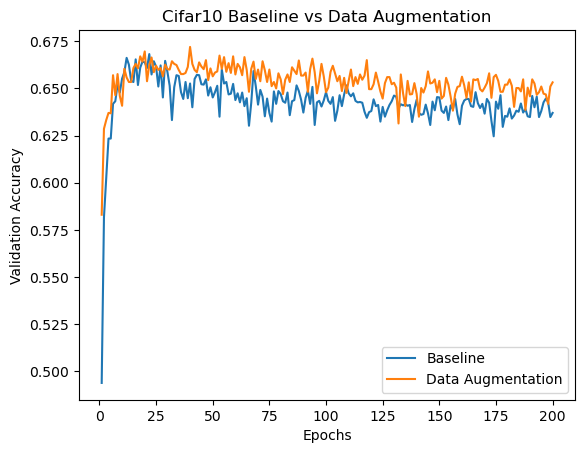

In [ ]:
#plot the test accuracies
#plot test accuracy
import matplotlib.pyplot as plt
folder = '/kaggle/working/'
csv_filename1 = 'baseline.csv'
df1 = pd.read_csv(folder + csv_filename1)
csv_filename2 = 'data-aug.csv'
df2 = pd.read_csv(folder + csv_filename2)

#plot the test accuracies from both DataFrames
plt.plot(df1['Epoch'], df1['Test Accuracy'], label='Baseline')
plt.plot(df2['Epoch'], df2['Test Accuracy'], label='Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Cifar10 Baseline vs Data Augmentation')
plt.show()

Q4.

In [39]:
from keras.datasets import cifar10
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
import os
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [40]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [41]:
#set aside 500 examples
x_train1 = x_train[-500:]
y_train1 = y_train[-500:]

a. Pretext

In [42]:
#assign class 0 to the 49500 images
x_train_class0 = x_train[:-500]
y_train_class0 = y_train[:-500]

In [43]:
#check the shape of the images
x_train1.shape, y_train1.shape, x_train_class0.shape, y_train_class0.shape

((500, 32, 32, 3), (500, 1), (49500, 32, 32, 3), (49500, 1))

In [44]:
#class 0 the 49500 x_train_unlabeled

#class 1 vertically flip upside down
x_train_class1 = x_train_class0[:,::-1,:,:]

#class 2 rotate images counterclockwise
x_train_class2 = np.rot90(x_train_class0, 1, (1,2))

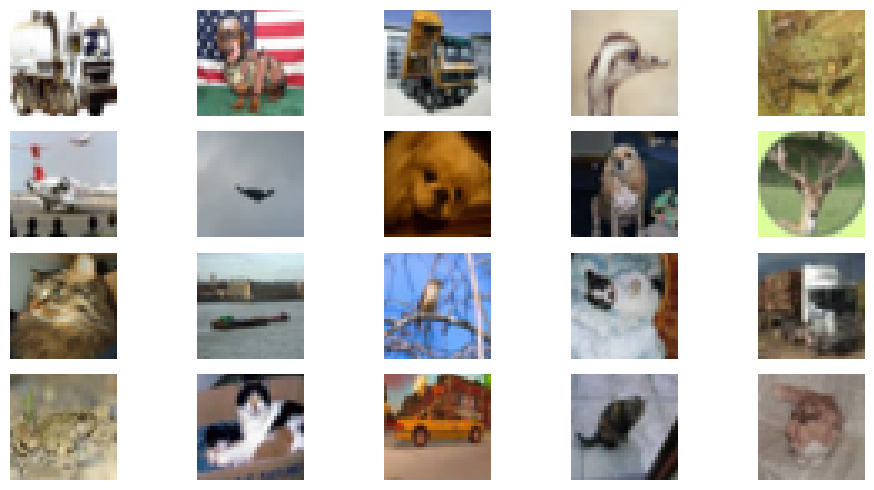

In [45]:
#print class 0 images - original
# Select 20 random indices
indices = np.random.choice(len(x_train_class0), 20)

# Plot the images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(indices):
    img = x_train_class0[idx]
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

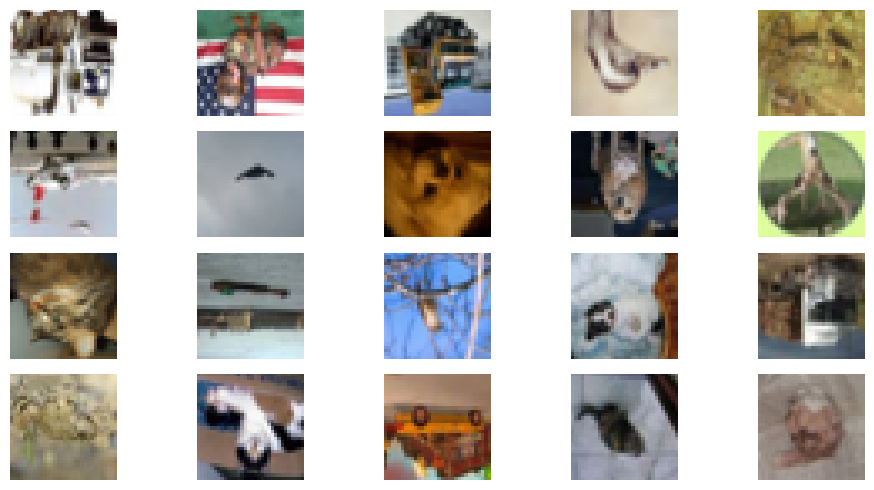

In [46]:
#print class 1 vertically flipped images

# Plot the images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(indices):
    img = x_train_class1[idx]
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

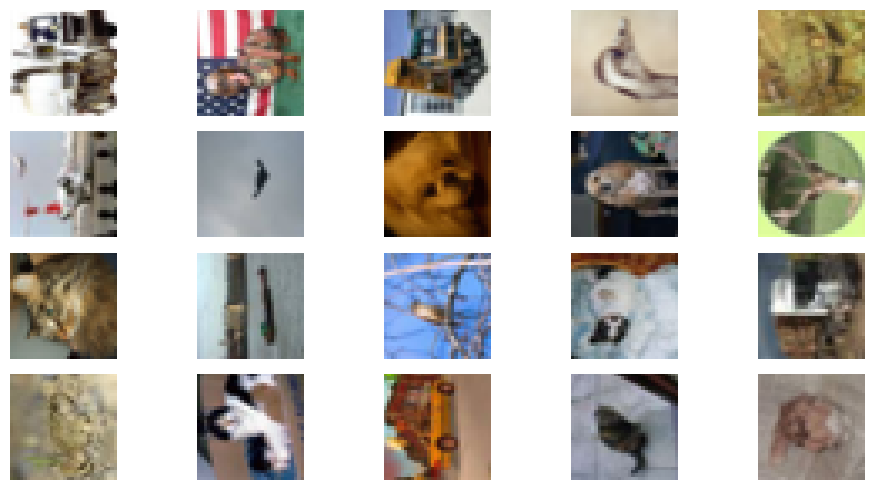

In [47]:
#class 2 rotated by 90 degrees counter clock

# Plot the images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(indices):
    img = x_train_class2[idx]
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [48]:
#concatenate the data
x_train_1 = np.concatenate([x_train_class0, x_train_class1, x_train_class2] , axis = 0)
y_train_1 = np.concatenate([np.zeros(len(x_train_class0)), 1*np.ones(len(x_train_class1)), 2*np.ones(len(x_train_class2))] , axis = 0)

In [49]:
x_train_1.shape , y_train_1.shape

((148500, 32, 32, 3), (148500,))

In [50]:
#categorical labels
#y_train_1 = keras.utils.to_categorical(y_train_1 , num_classes = 3)

In [51]:
#normalize the x_train from 0 to 1
x_train_1 = x_train_1 / 255.0

In [52]:
#model
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",input_shape = (32,32,3),
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Flatten())
model.add(Dense(20, activation = "relu", kernel_initializer = "he_normal"))
model.add(Dense(3, activation = "softmax"))

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 10)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_4 (Dense)             (None, 20)               

In [54]:
#with btch size 512 : 0.7889 categorical cross entropy
#batch size 512 sparse categorical

In [55]:
model.compile(optimizer = Adam(learning_rate = 0.001) , loss = "sparse_categorical_crossentropy" , metrics= ["accuracy"])
history_pretext = model.fit(x_train_1, y_train_1, epochs = 100 , batch_size = 512)

Epoch 1/100
291/291 [==============================] - 4s 6ms/step - loss: 0.8938 - accuracy: 0.5747
Epoch 2/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7725 - accuracy: 0.6575
Epoch 3/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7384 - accuracy: 0.6767
Epoch 4/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7210 - accuracy: 0.6864
Epoch 5/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7039 - accuracy: 0.6949
Epoch 6/100
291/291 [==============================] - 2s 6ms/step - loss: 0.6924 - accuracy: 0.7009
Epoch 7/100
291/291 [==============================] - 2s 6ms/step - loss: 0.6818 - accuracy: 0.7065
Epoch 8/100
291/291 [==============================] - 2s 6ms/step - loss: 0.6720 - accuracy: 0.7114
Epoch 9/100
291/291 [==============================] - 2s 6ms/step - loss: 0.6670 - accuracy: 0.7132
Epoch 10/100
291/291 [==============================] - 2s 6ms/step - loss: 0.6596 - accura

In [56]:
model.save("/content/gdrive/MyDrive/DLS/HW2/pretext.h5")

b. Baseline

In [57]:
x_train1.shape , y_train1.shape

((500, 32, 32, 3), (500, 1))

In [58]:
#normalize x train
x_train1 = x_train1 / 255.0

In [59]:
#normalize validation data
x_val = x_test / 255.0

In [60]:
#categorical labels
#y_train1 = keras.utils.to_categorical(y_train1, num_classes = 10)
#y_val = keras.utils.to_categorical(y_test, num_classes = 10)
y_val = y_test

In [61]:
#model
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",input_shape = (32,32,3),
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Conv2D(filters = 10, kernel_size = (5, 5) , strides = (1, 1), padding = "same",
                 activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Flatten())
model.add(Dense(20, activation = "relu" , kernel_initializer = "he_normal"))
model.add(Dense(10, activation = "softmax"))

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 10)        760       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 10)        2510      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 10)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 20)               

In [63]:
model.compile(optimizer = Adam(learning_rate = 0.001) , loss = "sparse_categorical_crossentropy" , metrics= ["accuracy"])
history_baseline = model.fit(x_train1, y_train1, epochs = 10000 , batch_size = 500, validation_data = (x_val, y_val))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 103ms/step - loss: 6.3416e-06 - accuracy: 1.0000 - val_loss: 13.6898 - val_accuracy: 0.3161
Epoch 7502/10000
1/1 [==============================] - 0s 108ms/step - loss: 6.3357e-06 - accuracy: 1.0000 - val_loss: 13.6909 - val_accuracy: 0.3162
Epoch 7503/10000
1/1 [==============================] - 0s 111ms/step - loss: 6.3288e-06 - accuracy: 1.0000 - val_loss: 13.6917 - val_accuracy: 0.3160
Epoch 7504/10000
1/1 [==============================] - 0s 109ms/step - loss: 6.3273e-06 - accuracy: 1.0000 - val_loss: 13.6919 - val_accuracy: 0.3159
Epoch 7505/10000
1/1 [==============================] - 0s 105ms/step - loss: 6.3252e-06 - accuracy: 1.0000 - val_loss: 13.6920 - val_accuracy: 0.3161
Epoch 7506/10000
1/1 [==============================] - 0s 101ms/step - loss: 6.3221e-06 - accuracy: 1.0000 - val_loss: 13.6923 - val_accuracy: 0.3162
Epoch 7507/10000
1/1 [==============================] - 0s 1

In [64]:
#write accuracies in a csv file
import pandas as pd
data = {'Epoch': list(range(1, len(history_baseline.history['val_accuracy']) + 1)),
        'Train Accuracy': history_baseline.history['accuracy'],
        'Test Accuracy': history_baseline.history['val_accuracy']}
df = pd.DataFrame(data)

folder = '/content/gdrive/MyDrive/DLS/HW2/'
#folder = "/kaggle/working/"
csv_filename = 'baseline-q4.csv'
df.to_csv(folder + csv_filename, index=False)

The model overfits at around 400-500 epoch as the training loss from there on is a constant and is a very small values and the training accuracy is around 100 %.

c. Transfer Learning

In [66]:
#load weights from pretext model
from keras.models import load_model
pretext_model = load_model('/content/gdrive/MyDrive/DLS/HW2/pretext.h5')

In [67]:
#remove the last layer of the model
pretext_features = pretext_model.layers[:-1]

In [68]:
model = Sequential()
for layer in pretext_features:
    weights = layer.get_weights()
    model.add(layer)
    model.layers[-1].set_weights(weights)

model.add(Dense(10, activation = "softmax", kernel_initializer = "he_normal"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 10)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_4 (Dense)             (None, 20)               

In [69]:
#last layer learning rate = 1e-3
#rest layers = 1e-5 /1e-6
#optimizers
opt1 = tf.keras.optimizers.Adam(learning_rate = 1e-5)
opt2 = tf.keras.optimizers.Adam(learning_rate = 1e-3)

optimizers = [opt1 , opt2]

In [70]:
#associate layers to it
optimizers_and_layers = [(optimizers[0], model.layers[:-1]), (optimizers[1], model.layers[-1])]

In [72]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.8 MB/s eta 0:00:00


In [73]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


- for softmax batch size = 500 xavier initialisation val acc 28%
- for softmax batch size = 500 default init 28%
- softmax he normal batch size = 32 30 till 1000 epoch
- sparse categorical he normal batch size = 500

In [74]:
model.compile( optimizer = optimizer, loss = "sparse_categorical_crossentropy" , metrics = ["accuracy"] )
history_tf = model.fit(x_train1, y_train1 , epochs = 10000, batch_size = 500, validation_data = (x_val, y_test))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 107ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 7.0265 - val_accuracy: 0.3416
Epoch 7502/10000
1/1 [==============================] - 0s 113ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 7.0277 - val_accuracy: 0.3417
Epoch 7503/10000
1/1 [==============================] - 0s 112ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 7.0288 - val_accuracy: 0.3418
Epoch 7504/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 7.0296 - val_accuracy: 0.3415
Epoch 7505/10000
1/1 [==============================] - 0s 106ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 7.0305 - val_accuracy: 0.3417
Epoch 7506/10000
1/1 [==============================] - 0s 111ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 7.0319 - val_accuracy: 0.3413
Epoch 7507/10000
1/1 [==============================] - 0s 111ms/step - loss: 0.0234 - acc

In [75]:
#write accuracies in a csv file
data = {'Epoch': list(range(1, len(history_tf.history['val_accuracy']) + 1)),
        'Train Accuracy': history_tf.history['accuracy'],
        'Test Accuracy': history_tf.history['val_accuracy']}
df = pd.DataFrame(data)

folder = '/content/gdrive/MyDrive/DLS/HW2/'
#folder = "/kaggle/working/"
csv_filename = 'transfer-learning-he-normal-q4.csv'
df.to_csv(folder + csv_filename, index=False)

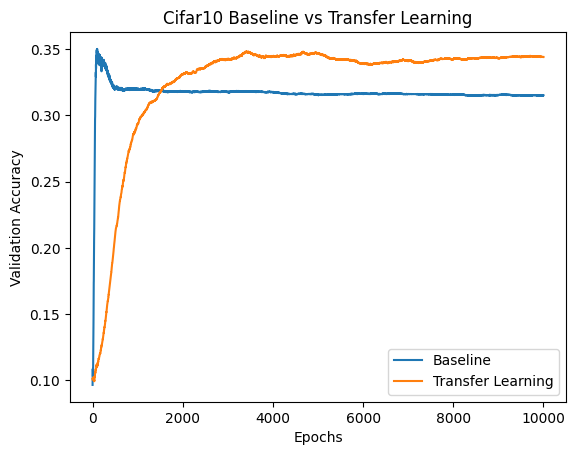

In [78]:
#plot the test accuracies
folder = '/content/gdrive/MyDrive/DLS/HW2/'
csv_filename1 = 'baseline-q4.csv'
df1 = pd.read_csv(folder + csv_filename1)
csv_filename2 = 'transfer-learning-he-normal-q4.csv'
df2 = pd.read_csv(folder + csv_filename2)

#plot the test accuracies from both DataFrames
plt.plot(df1['Epoch'], df1['Test Accuracy'], label='Baseline')
plt.plot(df2['Epoch'], df2['Test Accuracy'], label='Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Cifar10 Baseline vs Transfer Learning')
plt.show()

As we can see, the self supervised features learn better as compared to baseline architecture.